# [**Effet de la transformation des cibles dans le modèle de régression**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/6_1_compose/plot_transformed_target.ipynb)<br/>([*Effect of transforming the targets in regression model*](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html))

Dans cet exemple, nous donnons un aperçu de [**`TransformedTargetRegressor`**](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html). Nous utilisons deux exemples pour illustrer les avantages de la transformation des cibles avant d'apprendre un modèle de régression linéaire. Le premier exemple utilise des données synthétiques tandis que le second exemple est basé sur le jeu de données de logement Ames.

In [2]:
# Author: Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause

print(__doc__)

Automatically created module for IPython interactive environment


# Exemple synthétique

Un ensemble de données de régression aléatoires synthétiques est généré. Les cibles `y` sont modifiées en :
* traduisant toutes les cibles de manière à ce que toutes les entrées soient non négatives (en ajoutant la valeur absolue du plus petit `y`) et
* en appliquant une fonction exponentielle pour obtenir des cibles non linéaires qui ne peuvent pas être ajustées en utilisant un simple modèle linéaire.

Par conséquent, une fonction logarithmique (`np.log1p`) et une fonction exponentielle (`np.expm1`) seront utilisées pour transformer les cibles avant d'entraîner un modèle de régression linéaire et de l'utiliser pour la prédiction.

In [3]:
import numpy as np
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=10_000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

Ci-dessous, nous tracons les fonctions de densité de probabilité de la cible avant et après l'application des fonctions logarithmiques.

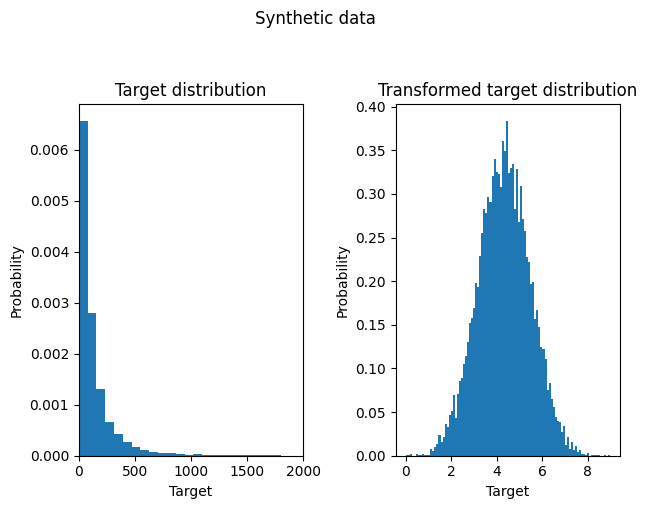

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([0, 2000])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Tout d'abord, un modèle linéaire sera appliqué sur les cibles originales. En raison de la non-linéarité, le modèle entraîné ne sera pas précis lors de la prédiction. Par la suite, une fonction logarithmique est utilisée pour linéariser les cibles, permettant une meilleure prédiction même avec un modèle linéaire similaire tel que rapporté par l'erreur absolue médiane (MedAE).

In [5]:
from sklearn.metrics import median_absolute_error, r2_score


def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

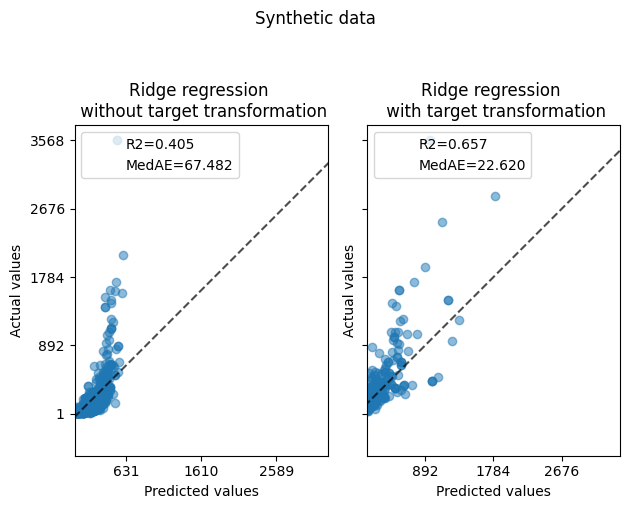

In [7]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

# Jeux de données réels

De manière similaire, le jeu de données de logement Ames est utilisé pour montrer l'impact de la transformation des cibles avant d'apprendre un modèle. Dans cet exemple, la cible à prédire est le prix de vente de chaque maison.

In [8]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import quantile_transform

ames = fetch_openml(name="house_prices", as_frame=True, parser="pandas")
# Keep only numeric columns
X = ames.data.select_dtypes(np.number)
# Remove columns with NaN or Inf values
X = X.drop(columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"])
# Let the price be in k$
y = ames.target / 1000
y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

Un [**`QuantileTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) est utilisé pour normaliser la distribution cible avant d'appliquer un modèle RidgeCV.

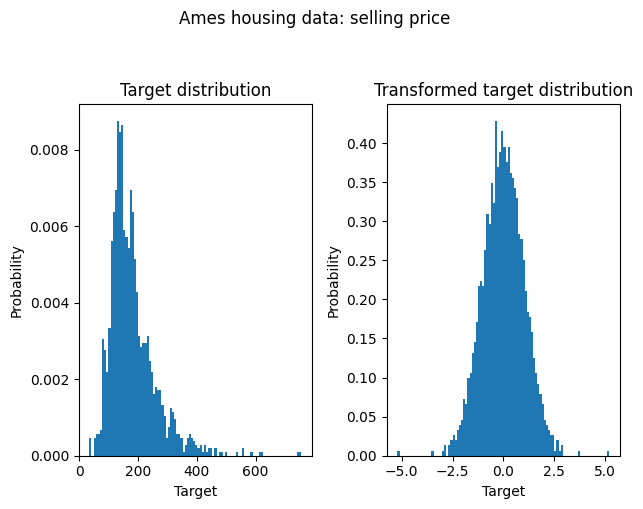

In [9]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

L'effet du transformateur est moins fort que sur les données synthétiques. Cependant, la transformation entraîne une augmentation de et une forte réduction de la MedAE. Le graphique de résidus (cible prédite - vraie cible vs cible prédite) sans transformation de la cible prend une forme incurvée, en forme de "sourire renversé" en raison de valeurs résiduelles qui varient en fonction de la valeur de la cible prédite. Avec la

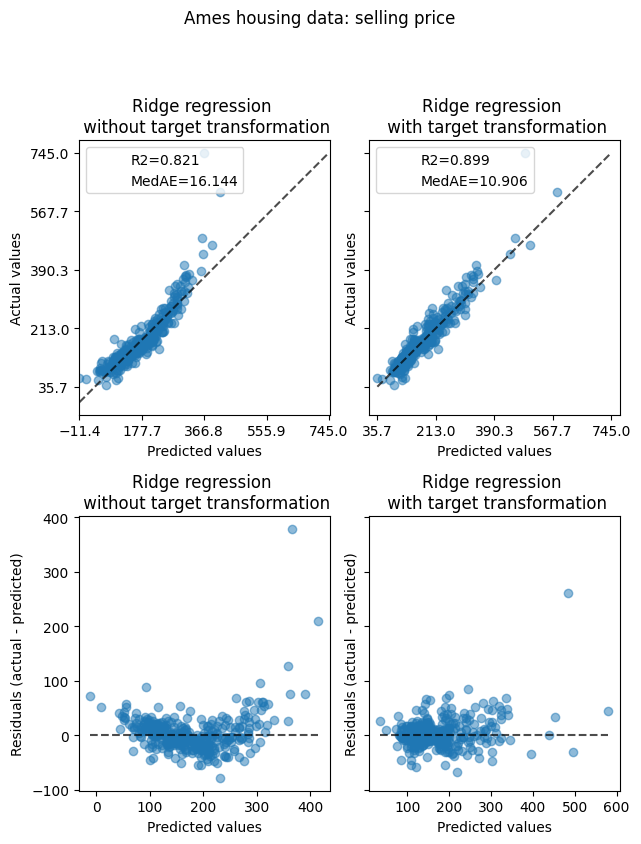

In [11]:
from sklearn.preprocessing import QuantileTransformer

f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

# plot the actual vs predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1]], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0[0].set_title("Ridge regression \n without target transformation")
ax0[1].set_title("Ridge regression \n with target transformation")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("Ridge regression \n without target transformation")
ax1[1].set_title("Ridge regression \n with target transformation")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()
plt.show()